<a href="https://colab.research.google.com/github/kumgleb/McKinsley_prohack_2020/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports:

In [ ]:
from google.colab import drive

drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
! pip install pygam
! pip install catboost

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 64.8MB 59kB/s 


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import missingno as msno 

import matplotlib.pyplot as plt
import seaborn as sns
import gc

from itertools import product
from pygam import LinearGAM

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor

from catboost import Pool
from catboost import CatBoostRegressor

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
np.random.seed(42)

# EDA:

In [ ]:
train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/train.csv')
test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/test.csv')

First of all, let's look at the data:

In [ ]:
train.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN,NaN,NaN,38.305483,681.841086,22.131436,150.259290,129.841789,12.403812,490.446400,60.121580,57.028183,69.825369,46

In the first part of the task, one should predict target variable `y` for specified `galaxy` according to `galaxy year`, let's inspect them:

In [ ]:
def inspect_train_test_feature_intersection(train_df, test_df, features=[], combination_of_features=[]):

  '''
  Function prints basic information about intersection of feature values
  in train and test data.
  
  `combination_of_features` - list of features those unique combinations are also inspected.
  '''

  for feature in features:
    print(f'Feature: "{feature}"')
    train_unique = train_df[feature].unique()
    print(f'  Train contains {len(train_unique)} unique values.')
    test_unique = test_df[feature].unique()
    print(f'  Test contains {len(test_unique)} unique values.')

    difference = len(train_unique) - len(test_unique)
    if difference > 0:
      print(f'  Train contains {difference} more unique values of the feature.')
    elif difference < 0:
      print(f'  Test contains {(-1)*difference} more unique values of the feature.')
    else:
      print(' Amount unique values of feature are the same in train and test.')
    print('-----------\n')

  if combination_of_features:
    print('Combinations of features:', combination_of_features)

    features_list = []
    train_and_test = pd.concat([train, test])
    for feature in combination_of_features:
      features_list.append(list(train_and_test[feature].unique()))
    
    features_combinations = pd.DataFrame(list(product(*features_list)),
                                         columns=combination_of_features)
    unique_combinations_num = features_combinations.shape[0]
    print(f'  There are {unique_combinations_num} unique combinations are possible.')

    train_fc_unique = pd.merge(features_combinations, train_df,
                               on=combination_of_features, how='inner')
    unique_train_combinations_num = train_fc_unique.shape[0]
    print(f'  There are {unique_train_combinations_num} unique combinations in train.')
    
    test_fc_unique = pd.merge(features_combinations, test_df,
                              on=combination_of_features, how='inner')    
    unique_test_combinations_num = test_fc_unique.shape[0]
    print(f'  There are {unique_test_combinations_num} unique combinations in test.')

    train_test_fc_intersection = pd.merge(train_fc_unique, test_fc_unique,
                                          on=combination_of_features, how='inner')
    intersections_num = train_test_fc_intersection.shape[0] 
    if intersections_num == unique_test_combinations_num:
      print(' There are no new fature combinations in a test set.')
    elif intersections_num < unique_test_combinations_num:
      print(f'  There are {unique_test_combinations_num - intersections_num} more feature combinations in the test set rather than in train.')


In [ ]:
inspect_train_test_feature_intersection(train, test, features=['galaxy', 'galactic year'],
                                        combination_of_features=['galaxy', 'galactic year'])

Feature: "galaxy"
  Train contain 181 unique values.
  Test contain 172 unique values.
  Train contains 9 more unique values for feature.
-----------

Feature: "galactic year"
  Train contain 26 unique values.
  Test contain 10 unique values.
  Train contains 16 more unique values for feature.
-----------

Combinations of features: ['galaxy', 'galactic year']
  There are 4887 unique combinations are possible.
  There are 3865 unique combinations in train.
  There are 890 unique combinations in test.
  There are 890 more fature combinations in a test set rather then in train.


**Main takeaways:**


1.   In the test set we deal with same galaxies as in the train set.
2.   As all combinations of 'galaxy' + 'galactic year' in the test set are different from the train set, it is likely that we deal with different years for train and test.

<br/>




Let's inspect years distribution in train and tests:

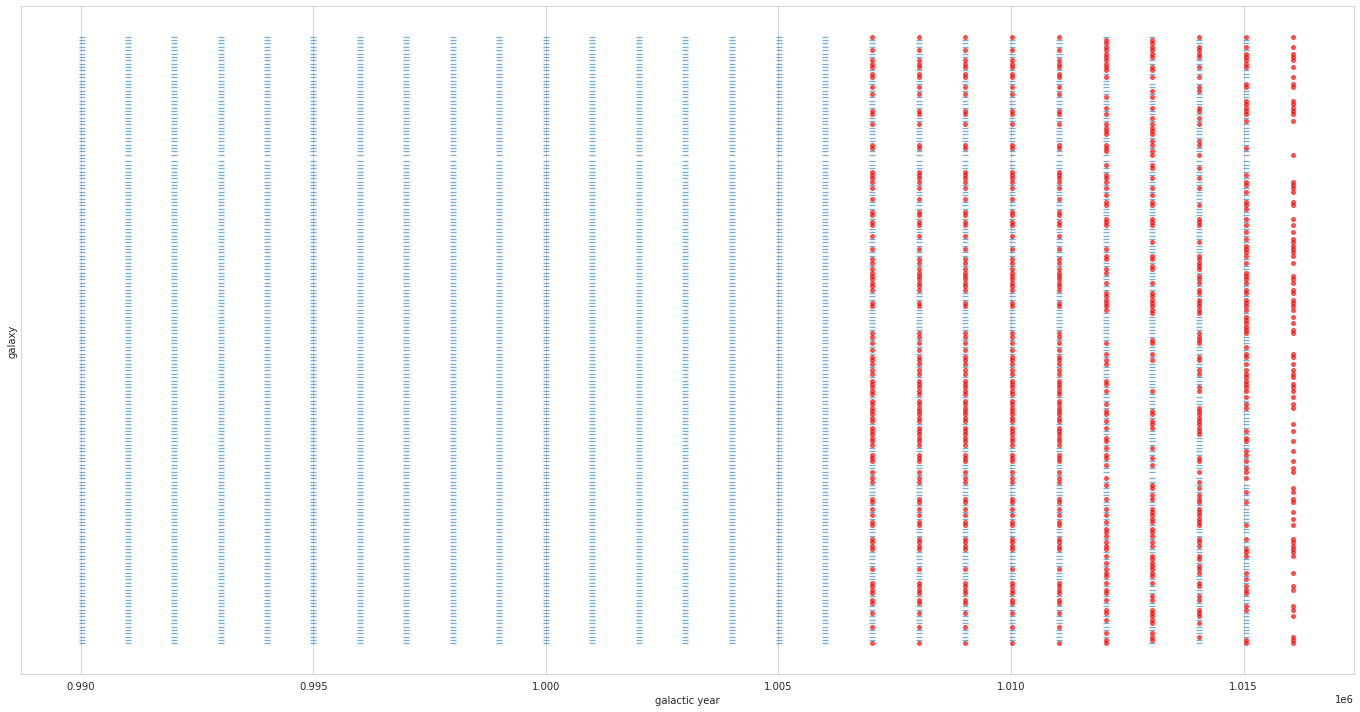

In [ ]:
fig, ax = plt.subplots(figsize=(19, 10))
sns.set_style("whitegrid")

sns.scatterplot(train['galactic year'], train.galaxy, marker='_', linewidth=1.3, alpha=0.6, s=30, ax=ax)
sns.scatterplot(test['galactic year'], test.galaxy, color='r', linewidth=0, alpha=0.7, s=25, ax=ax)
ax.set_yticklabels([])
ax.set_yticks([]) 

fig.tight_layout()

In [ ]:
train_test_spit_trsh_year = test['galactic year'].min()
print(f'Train treshold year: {train_test_spit_trsh_year}')

Train treshold year: 1007012


Here we can realise how data was divided in train and test: 


1.   For every galaxy the test set represents years >= 1007012 year.
2.   For most test cases we should predict target for year that out of train set years range (last year - future prediction).
3. Every combination of galaxy and year is unique in train and test sets. <br>


Validation strategy should be based with respect to properties above.




---



At first glance, there is a lot of NaNs in data, let's visualise them:

Percent of train missing values: 60.1%
Percent of test missing values: 28.2%


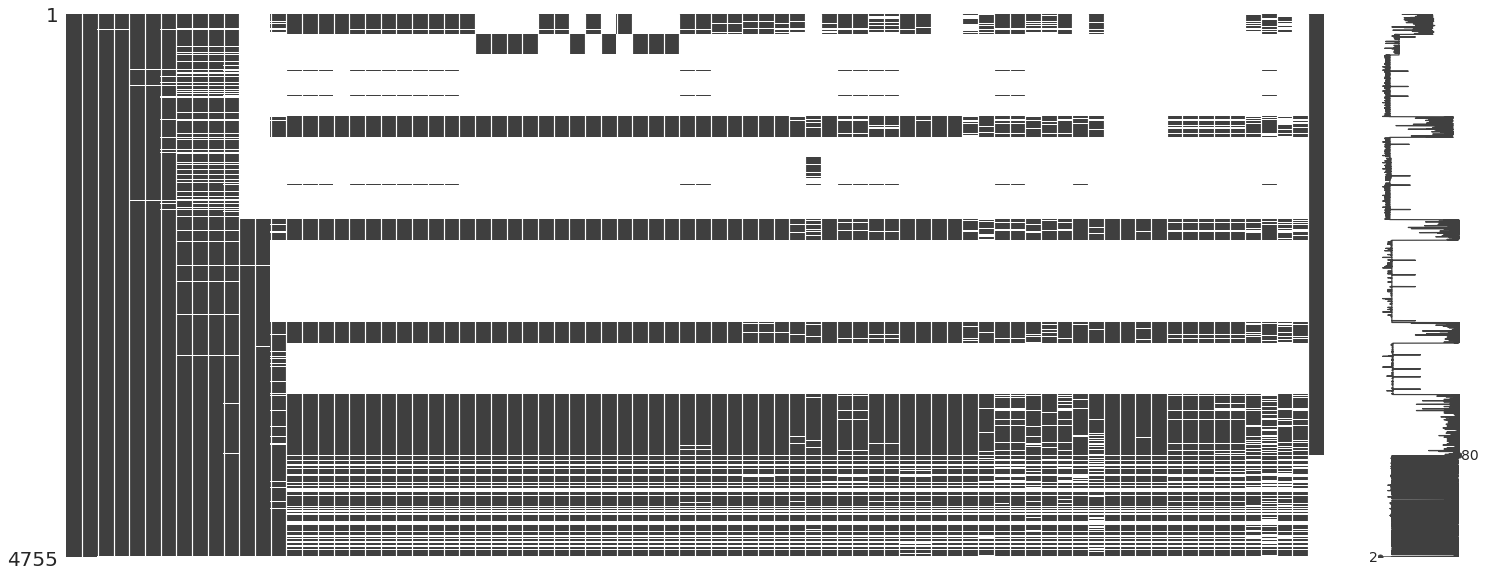

In [ ]:
train_and_test = pd.concat([train, test])

msno.matrix(train_and_test)
print(f'Percent of train missing values: {train.isna().sum().sum()/train.shape[0]/train.shape[1]*100:.1f}%')
print(f'Percent of test missing values: {test.isna().sum().sum()/test.shape[0]/test.shape[1]*100:.1f}%')

White areas above represent missing values. <br>
There is a huge amount of missing values, as one can see there are some galaxies with approximetly no data at all. <br>
There may be several different ways to tackle this problem:


1.   This is clear that we deal with real countires and years (aka "galaxies" and "galactic years", there are 181 unique 'galaxies' and 195 countries in a real world). It may be possible to reconstruct real countries and years, then try to collect missing data (like 'Gross income' or 'Unemployment rate' etc). Also it may be possible to calculate some indexes using special formulas (for example, Income index).   
2.   As we deal with consequential data, we can try to interpolate missing values with respect to years.
3. It is also possible to predict missing values using a model trained on avaliable data.
4. One can just simply fill missing data with some feature statistics like mean or median. <br>
5. Also we can just get rid of features with lot of Nan's.

In our case, because of lack of data for some galaxies, it will be inadequate to use approach #4 and impossible to use approach #2 for all galaxies with missing data. <br>
Approach #2 may be used for some of galaxies with moderate amount of missing data. <br>
Approach #1 seems promising, but also very demanding. <br>
Approach #3 also seems promising, especially combined with #2 where possible.
Approach #5 ignores a lot of data, but it is very easy to implement.


Before diving in one of above aproaches let's explore correlations between target and almost complete features and target. For this I define several helping functions:

In [ ]:
def get_good_features(train_df, test_df, nans_ratio_treshold=0.8):

  '''
  Function returns list of features
  with percent of Nan in train and test are less than `nans_ratio_treshold`.
  '''

  train_and_test = pd.concat([train, test])
  train_and_test.drop('y', axis=1, inplace=True)

  good_features = []
  N = train_and_test.shape[0]

  for feature in train_and_test.columns:
    if train_and_test[feature].isna().sum() / N < 1 - nans_ratio_treshold:
      good_features.append(feature)

  return good_features

In [ ]:
def get_galaxy_samples(train_df, n_galaxys, min_years=15):

  '''
  Function returns `n_galaxys` random samples with 
  amount of galactic years not less than `min_years`.
  '''

  galaxy_sample = set()
  while len(galaxy_sample) < n_galaxys:
    galaxy = train_df.galaxy.sample(1).values[0]
    if len(train_df[train_df['galaxy'] == galaxy]['galactic year']) > min_years:
      galaxy_sample.add(galaxy)

  galaxy_sample = [glxy for glxy in galaxy_sample]

  return galaxy_sample

Now we can plot correlations for several random galaxys which are representative, as we choose only ones with more than 15 galactic years data. <br>
In order to visualise it in a more simple way, I plot correlations with absolute value not less then 0.7:

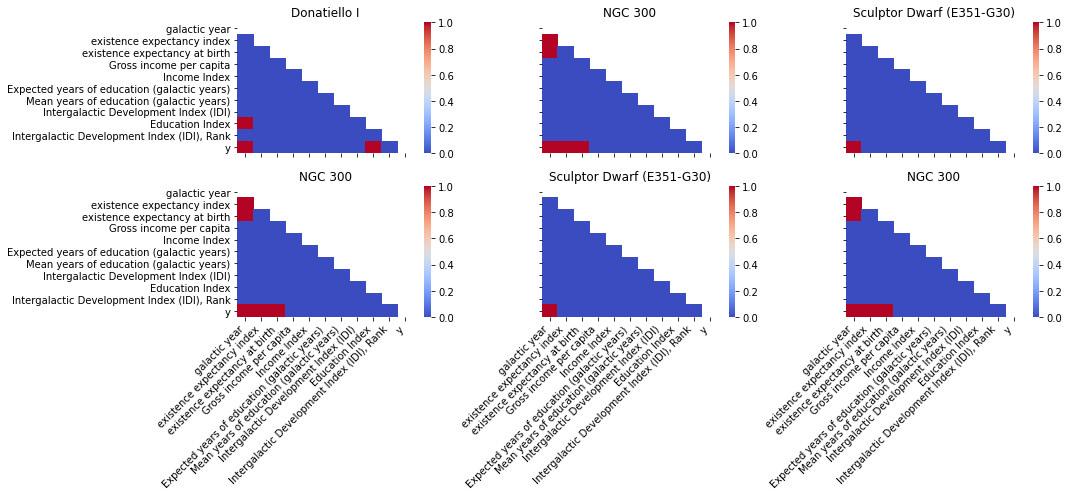

In [ ]:
good_features = get_good_features(train, test)
galaxy_samples = get_galaxy_samples(train, 6)

# removing categorical variable from features set
good_features.remove('galaxy')

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 7))

for i in range(2):
  for j in range(3):
    galaxy = galaxy_samples[i+j]
    train_galaxy_subset = train[train['galaxy'] == galaxy].copy()
    train_subset = train_galaxy_subset[good_features]

    corr_mat = np.abs(train_subset.corr()) > 0.7

    mask = np.zeros_like(corr_mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    hm = sns.heatmap(corr_mat, annot=False, mask=mask,
                     cmap="coolwarm", ax=ax[i][j])
    hm.set_xticklabels(hm.get_xticklabels(), 
                       horizontalalignment='right', rotation=45)
    ax[i][j].set_title(galaxy)

fig.tight_layout()

As one can see there are high correlation with year for every galaxy from samples. <br>
For half of them there are also high correlation between target `y` and `existance expectancy index` and `existance expectancy at birth`, so let's explore them in more details:

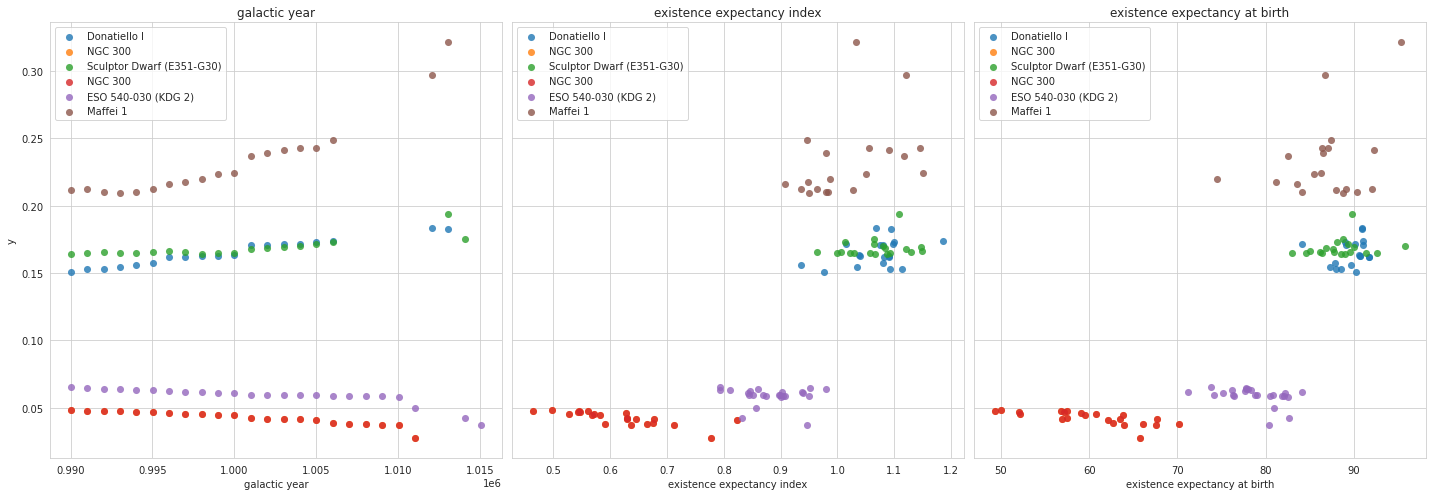

In [ ]:
features_to_explore = ['galactic year', 'existence expectancy index', 'existence expectancy at birth']

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 7))

for i, feature in enumerate(features_to_explore):
  for galaxy in galaxy_samples:
    train_galaxy_subset = train[train['galaxy'] == galaxy].copy()
    sns.scatterplot(train_galaxy_subset[feature], train_galaxy_subset['y'],
                    s=50, alpha=0.8, linewidth=0, label=galaxy, ax=ax[i])
    
  ax[i].set_title(feature)

fig.tight_layout()

Here one can see that `existence expectancy index` and `existence expectancy at birth` are strongly correlated features, that is why only one can be considered. <br>
What is more important is that it seems target can be nearly perfectly described only by `galactic year` using some interpolation and extrapolations.

There are some features with small amount of nans, so they can be used for another model. <br>

In [ ]:
good_features = get_good_features(train, test, nans_ratio_treshold=0.8)

print(f'There are {len(good_features)} features with less then 80% nan per feature.')

There are 11 features with less then 80% nan per feature.


In [ ]:
def check_missing_values(train_df, test_df):

  df = pd.concat([train_df, test_df])
  df.drop('y', axis=1, inplace=True)
  nan_ratio = df.isna().sum().sum() / df.shape[0] * 100

  for feature in good_features:
    nan_ratio = df[feature].isna().sum() / df.shape[0] * 100
    if nan_ratio > 0:
      max_nans = 0
      max_nans_glxy = 0
      for glxy in df.galaxy.unique():
        glxy_ftr_nans = (df[df['galaxy'] == glxy][feature].isna().sum() /
                        df[df['galaxy'] == glxy].shape[0] * 100)
        if glxy_ftr_nans > max_nans:
          max_nans_glxy = glxy
          max_nans = glxy_ftr_nans

    print(f'There are {nan_ratio:.1f}% nans in column {feature}')
    if nan_ratio > 0:
      print(f'  max nans in galaxy {max_nans_glxy}, {max_nans:.2f}%. \n')

Let's see distribution of nan's in those features in more detail:

In [ ]:
train_subset = train[good_features + ['y']].copy()
test_subset = test[good_features].copy()

check_missing_values(train_subset, test_subset)

There are 38.4% of outliers in train and test subsets. 

There are 0.0% nans in column galactic year
There are 0.0% nans in column galaxy
There are 0.1% nans in column existence expectancy index
  max nans in galaxy NGC 5253, 100.00%. 

There are 0.1% nans in column existence expectancy at birth
  max nans in galaxy NGC 5253, 100.00%. 

There are 0.7% nans in column Gross income per capita
  max nans in galaxy UGC 8651 (DDO 181), 69.23%. 

There are 0.7% nans in column Income Index
  max nans in galaxy UGC 8651 (DDO 181), 69.23%. 

There are 2.9% nans in column Expected years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There are 7.8% nans in column Mean years of education (galactic years)
  max nans in galaxy NGC 5253, 100.00%. 

There are 8.4% nans in column Intergalactic Development Index (IDI)
  max nans in galaxy NGC 5253, 100.00%. 

There are 8.4% nans in column Education Index
  max nans in galaxy NGC 5253, 100.00%. 

There are 9.3% nans in column Inte

As one can see there are no more then 9.3% of missing values for column, but 100% of missing values for some galaxys.

**EDA main conclusions:**
1. Validation strategy should be done with respect to the time component (`galactic year`).
2. Because of high correlation between target and `galactic year`, a good predictive model, which uses just this feature, can be created.
3. There are 11 features with less than 20% Nans. They can be used for a separate model.
4. There are about 60% of Nans in raw train set. If above described approaches (2 and 3) would not perform good enough, one of the approaches (described above) can be used for filling missing values.
5. Features with small amount of nans can be used for a separate model.




---

